<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install --upgrade tonic_validate

In [53]:
!pip install --upgrade openai

In [54]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [55]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize OpenAI

In [56]:
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

client = OpenAI()

Load benchmark questions & answers

In [57]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define OpenAI helper functions

In [58]:
def upload_essays():
    file_ids = []

    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    vector_store = client.beta.vector_stores.create(
      name="OpenAI Rag Test"
    )

    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    file_streams = [open(path, "rb") for path in file_paths]

    file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
      vector_store_id=vector_store.id, files=file_streams
    )

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return vector_store.id

def create_assistant(vector_store_id):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-turbo",
        tools=[{"type": "file_search"}],
        tool_resources={
          "file_search": {
            "vector_store_ids": [vector_store_id]
          }
        }
    )

# WARNING
# this deletes all vector stores associated with your openai api key.
def cleanup_vector_stores():
    for v in client.beta.vector_stores.list():
        client.beta.vector_stores.delete(v.id)

        print(f'Deleted vector store [{v.id}].')
        time.sleep(5)

def cleanup_files():
    for f in client.files.list():
        client.files.delete(f.id)

        print(f'Deleted file [{f.id}].')
        time.sleep(1)

Define OpenAI RAG function

In [59]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 10
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0:
                message = messages.data[0]

                if len(message.content)>0:
                    content = message.content[0]

                    response_message = content.text.value
                    if response_message != prompt and response_message.strip():
                        client.beta.threads.delete(thread.id)
                        return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

Initialize OpenAI test

In [60]:
#cleanup_vector_stores()
#cleanup_files()

assistant = None

vector_store_id = upload_essays()

if vector_store_id is not None:
    print(f'Essays ingested into vector store [{vector_store_id}].')

    assistant = create_assistant(vector_store_id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/vector_stores "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST ht

Uploading essays took 36.68 seconds. Finished at 07:50:59 UTC.
Essays ingested into vector store [vs_OFNdbJExnLvQkSLj5B4FfdNS].


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/assistants "HTTP/1.1 200 OK"


Validate OpenAI response

In [61]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/runs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thread_FIwuiNsE1HU6Yc6rE64OEv08/messages "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/threads/thre

According to Paul Graham, the key components necessary to create a technology hub are primarily two types of people: rich individuals and nerds. He identifies these two groups as essential because they are typically present at the inception of startups. Rich people, particularly those with experience and success in the technology sector, are crucial not only for their financial investment but also for their advice and connections. The presence of 'nerds' or highly skilled and innovative technical experts is equally vital as they are the primary force behind the technological innovation and development that characterize successful tech hubs .


Perform OpenAI test and score run

In [62]:
import asyncio

async def run_test():
    with ThreadPoolExecutor() as executor:
        tasks = []
        for item in benchmark.items:
            task = asyncio.get_event_loop().run_in_executor(executor, get_openai_rag_response, item, assistant)
            tasks.append(task)

        return await asyncio.gather(*tasks)

raw_openai_responses = await run_test()

print(raw_openai_responses)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads/thread_w5hL1vJzOczZMSJBqdWd1N7e/runs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads/thread_CGT7cNEVo4BbxggKiqzBNJTY/runs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads/thread_bWKnkUAviiFunlfVWx75lR13/runs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/threads/thread_eEwGJ68P5Dsuufv6HPYBqc1b/runs "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST ht

['Paul Graham identifies several key components that are essential for creating a technology hub. These components are:\n\n1. **Rich People** - Wealthy individuals are crucial because they can invest in new startups.\n\n2. **Nerds** - A concentration of smart, ambitious people who are focused on technology or related fields is necessary. These individuals drive innovation and entrepreneurial spirit.\n\n3. **Good Universities** - High-quality universities help in two ways. First, they act as a source of new talent and innovation. Second, they contribute to an environment that values learning and experimentation.\n\n4. **Personality** - Graham emphasizes that hubs need not only structural components like money and talent but also a certain cultural or personality element. This might involve openness to new ideas, a non-conformity attitude, and a lack of bureaucracy.\n\n5. **Quality of Life** - A technology hub needs to offer a good quality of life to attract and retain talented people. T

In [63]:
openai_responses = [
    LLMResponse(
        llm_answer=r if r is not None else "", llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [64]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses, parallelism=5)

Scoring responses:   5%|▌         | 3/55 [00:00<00:11,  4.61it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  15%|█▍        | 8/55 [00:01<00:06,  7.24it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  20%|██        | 11/55 [00:01<00:07,  6.18it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  24%|██▎       | 13/55 [00:02<00:06,  6.91it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx

In [65]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv(f"{tonic_validate_directory}/openai_run.csv", index=False)

Visualize OpenAI test

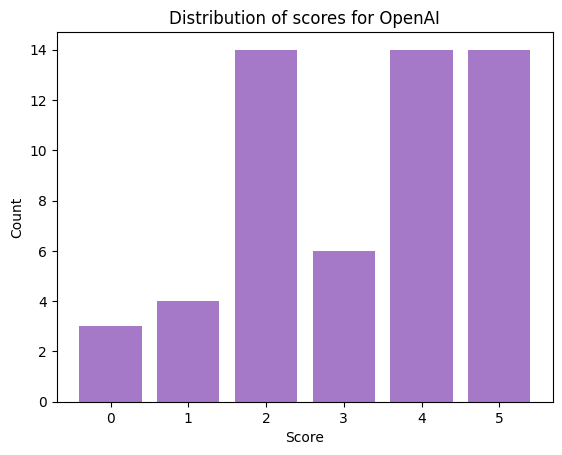

In [66]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()